Dictionary keys being frequencies, values are np arrays of `Nc x Ns x Nt` (channels x samples x trials). 

First import the data from one session

In [5]:
data_file_7 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\7hz\7hz_LED.txt","r")
data_file_7 = data_file_7.read().split(', ')
for i, v in enumerate(data_file_7):
    if '[' in v:
        data_file_7[i] = v.replace('[','')
    if ']\n' in v:
        data_file_7[i] = v.replace(']\n','')

values_7 = [int(i) for i in data_file_7]

data_file_10 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\10hz\10hz_LED.txt", "r")
data_file_10 = data_file_10.read().split(', ')
for i, v in enumerate(data_file_10):
    if '[' in v:
        data_file_10[i] = v.replace('[','')
    if ']\n' in v:
        data_file_10[i] = v.replace(']\n','')

values_10 = [int(i) for i in data_file_10]

data_file_12 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\12hz\12hz_LED.txt", "r")
data_file_12 = data_file_12.read().split(', ')
for i, v in enumerate(data_file_12):
    if '[' in v:
        data_file_12[i] = v.replace('[','')
    if ']\n' in v:
        data_file_12[i] = v.replace(']\n','')

values_12 = [int(i) for i in data_file_12]

Passband the values

Elliptical 10th order bandpass filter with corner frequencies at (4, 28)Hz,
0.2dB passband ripple and 80dB stopband atten

i.e the same filter that will happen on the board

In [6]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

fs = 256
filt_ord = 10
pb_rip = 0.2
sb_atten = 80

fc_lo = 4 # pass band lower freq
fc_hi = 28 # pass band upp freq 
wc_lo = fc_lo/(fs*0.5)
wc_hi = fc_hi/(fs*0.5)

sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')

filtered = signal.sosfilt(sos_ellip, values_10[::2])

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

filtered_new = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_10[::2])

filtered = filtered[256:]
filtered_board = filtered_new[256:]

Text(0.5, 1.0, 'Filtered board')

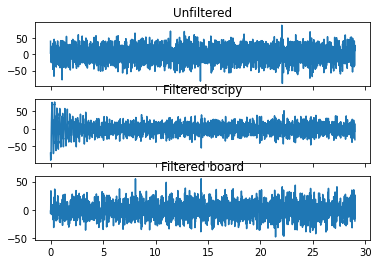

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
t = np.linspace(0, 29, len(values_10[512::2]), False)

ax1.plot(t, values_10[512::2]-np.mean(values_10[512::2]))
ax1.set_title('Unfiltered')

ax2.plot(t, filtered)
ax2.set_title('Filtered scipy')

ax3.plot(t, filtered_board - np.mean(filtered_board))
ax3.set_title('Filtered board')

Decoding section

GCCA, MsetCCA

In [21]:
from scipy import signal
import numpy as np

freqs =[7,10,12]
downsample_avg_size = 2

filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_10)
filtered_10 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_10)]*downsample_avg_size)])[256:]

filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_12)
filtered_12 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_12)]*downsample_avg_size)])[256:]

filtered_7 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_7)
filtered_7 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_7)]*downsample_avg_size)])[256:]

print(filtered_7.shape)
print(filtered_10.shape)
print(filtered_12.shape)

(7439,)
(7439,)
(7439,)


In [22]:
number_of_train = 4
fs = 256

# synth_7 = (synth_X(7,1,256,4).T).reshape(1,fs,4)

train7_reshape = np.array(filtered_7[:fs*number_of_train]).reshape(number_of_train,fs)
train7 = train7_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train = np.array([train7, train10, train12])

test7 = filtered_7[fs*number_of_train:]
test10 = filtered_10[fs*number_of_train:]
test12 = filtered_12[fs*number_of_train:]

In [23]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_7 = []
mset_7 =[]

for begin in range(0, int(len(test7)/256)):
    gcca_decode = gcca.classify(test7[256*begin:256*begin+256].reshape(1,256))
    gcca_7.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test7[256*begin:256*begin+256].reshape(1,256))
    mset_7.append(max(mset_decode, key=mset_decode.get))

print(gcca_7.count(7)/len(gcca_7), '\n', mset_7.count(7)/len(mset_7))

gcca_10 = []
mset_10 =[]

for begin in range(0, int(len(test10)/256)):
    gcca_decode = gcca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print(gcca_10.count(10)/len(gcca_10), '\n', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/256)):
    gcca_decode = gcca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print(gcca_12.count(12)/len(gcca_12), '\n', mset_12.count(12)/len(mset_12))

0.2 
 0.48
0.36 
 0.32
0.16 
 0.32


# Using online dataset

In [25]:
import pandas as pd
from scipy import signal
import numpy as np
import math
from eeg_lib.utils import standardise

df = pd.read_csv(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\online_dataset\data\subject1.csv",sep=';')
s1_8_57 = standardise(df['F1'].to_numpy())
s1_10 = standardise(df['F2'].to_numpy())
s1_12 = standardise(df['F3'].to_numpy())
s1_15 = standardise(df['F4'].to_numpy())


(4096,)
(4096,)
(4096,)
(4096,)


In [26]:
freqs =[8.57,10,12,15]
fs = 256
number_of_train = 4

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

filtered_857 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_8_57)
filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_10)
filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_12)
filtered_15 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_15)

# filtered_857 = s1_8_57
# filtered_10 = s1_10
# filtered_12 = s1_12
# filtered_15 = s1_15


train857_reshape = np.array(filtered_857[:fs*number_of_train]).reshape(number_of_train,fs)
train857 = train857_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train15_reshape = np.array(filtered_15[:fs*number_of_train]).reshape(number_of_train,fs)
train15 = train15_reshape.T.reshape(1,fs,number_of_train)


# train857 = np.array(filtered_857[len(filtered_857)-256*number_of_train:]).reshape(1,256,number_of_train)
# train10 = np.array(filtered_10[len(filtered_10)-256*number_of_train:]).reshape(1,256,number_of_train)
# train12 = np.array(filtered_12[len(filtered_12)-256*number_of_train:]).reshape(1,256,number_of_train)
# train15 = np.array(filtered_15[len(filtered_15)-256*number_of_train:]).reshape(1,256,number_of_train)

train = np.array([train857, train10, train12, train15])

test857 = filtered_857[256*number_of_train:]
test10= filtered_10[256*number_of_train:]
test12 = filtered_12[256*number_of_train:]
test15 = filtered_15[256*number_of_train:]

# test857 = filtered_857[:len(filtered_857)-256*number_of_train]
# test10= filtered_10[:len(filtered_10)-256*number_of_train]
# test12 = filtered_12[:len(filtered_12)-256*number_of_train]
# test15 = filtered_15[:len(filtered_15)-256*number_of_train]

In [27]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_857 = []
mset_857 =[]

for begin in range(0, int(len(test857)/256)):
    gcca_decode = gcca.classify(test857[256*begin:256*begin+256].reshape(1,256))
    gcca_857.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test857[256*begin:256*begin+256].reshape(1,256))
    mset_857.append(max(mset_decode, key=mset_decode.get))

print("GCCA 8.57hz accuracy: ", gcca_857.count(7)/len(gcca_857), '\nMset 8.57hz accuracy: ', mset_857.count(7)/len(mset_857))

gcca_10 = []
mset_10 =[]

for begin in range(0, int(len(test10)/256)):
    gcca_decode = gcca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[256*begin:256*begin+256].reshape(1,256))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print("GCCA 10hz accuracy: ",gcca_10.count(10)/len(gcca_10), '\nMset 10hz accuracy: ', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/256)):
    gcca_decode = gcca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[256*begin:256*begin+256].reshape(1,256))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print("GCCA 12hz accuracy: ",gcca_12.count(12)/len(gcca_12), '\nMset 12hz accuracy: ', mset_12.count(12)/len(mset_12))

gcca_15 = []
mset_15 =[]

for begin in range(0, int(len(test15)/256)):
    gcca_decode = gcca.classify(test15[256*begin:256*begin+256].reshape(1,256))
    gcca_15.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test15[256*begin:256*begin+256].reshape(1,256))
    mset_15.append(max(mset_decode, key=mset_decode.get))

print("GCCA 15hz accuracy: ",gcca_15.count(15)/len(gcca_15), '\nMset 15hz accuracy: ', mset_15.count(15)/len(mset_15))

GCCA 8.57hz accuracy:  0.0 
Mset 8.57hz accuracy:  0.0
GCCA 10hz accuracy:  0.08333333333333333 
Mset 10hz accuracy:  0.08333333333333333
GCCA 12hz accuracy:  0.5833333333333334 
Mset 12hz accuracy:  0.4166666666666667
GCCA 15hz accuracy:  0.25 
Mset 15hz accuracy:  0.16666666666666666


# 64hz over 4 second approach - own data

In [29]:
import numpy as np
from scipy import signal

data_file_7 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\7hz\7hz_LED2.txt", "r")
data_file_7 = data_file_7.read().split(', ')
for i, v in enumerate(data_file_7):
    if '[' in v:
        data_file_7[i] = v.replace('[','')
    if ']\n' in v:
        data_file_7[i] = v.replace(']\n','')

downsample_avg_size = 2

values_7 = [int(i) for i in data_file_7]
values_7 = [sum(group) / downsample_avg_size for group in zip(*[iter(values_7)]*downsample_avg_size)]

data_file_10 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\10hz\10hz_LED2.txt", "r")
data_file_10 = data_file_10.read().split(', ')
for i, v in enumerate(data_file_10):
    if '[' in v:
        data_file_10[i] = v.replace('[','')
    if ']\n' in v:
        data_file_10[i] = v.replace(']\n','')

values_10 = [int(i) for i in data_file_10]
values_10 = [sum(group) / downsample_avg_size for group in zip(*[iter(values_10)]*downsample_avg_size)]

data_file_12 = open(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\fs512hz_gain255_30s\12hz\12hz_LED2.txt", "r")
data_file_12 = data_file_12.read().split(', ')
for i, v in enumerate(data_file_12):
    if '[' in v:
        data_file_12[i] = v.replace('[','')
    if ']\n' in v:
        data_file_12[i] = v.replace(']\n','')

values_12 = [int(i) for i in data_file_12] #because sampled at 512, sos filter uses 256
values_12 = [sum(group) / downsample_avg_size for group in zip(*[iter(values_12)]*downsample_avg_size)]

In [30]:
print(len(values_12), len(values_10),len(values_7) )

7695 7695 7695


In [32]:
freqs =[7,10,12]
fs = 256

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

downsample_avg_size = 2

filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_10)
filtered_10 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_10)]*downsample_avg_size)])

filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_12)
filtered_12 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_12)]*downsample_avg_size)])

filtered_7 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values_7)
filtered_7 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_7)]*downsample_avg_size)])

print(filtered_7.shape)
print(filtered_10.shape)
print(filtered_12.shape)

(3847,)
(3847,)
(3847,)


In [33]:
number_of_train = 4

train7_reshape = np.array(filtered_7[:fs*number_of_train]).reshape(number_of_train,fs)
train7 = train7_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train = np.array([train7, train10, train12])
test7 = filtered_7[fs*number_of_train:]
test10= filtered_10[fs*number_of_train:]
test12 = filtered_12[fs*number_of_train:]

In [34]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs=128, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_7 = []
mset_7 =[]

for begin in range(0, int(len(test7)/fs)):
    gcca_decode = gcca.classify(test7[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_7.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test7[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_7.append(max(mset_decode, key=mset_decode.get))

print("GCCA 7hz accuracy: ",gcca_7.count(7)/len(gcca_7), '\nMset 7hz accuracy: ', mset_7.count(7)/len(mset_7))

gcca_10 = []
mset_10 =[]

for begin in range(0, int(len(test10)/fs)):
    gcca_decode = gcca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print("GCCA 10hz accuracy: ",gcca_10.count(10)/len(gcca_10), '\nMset 10hz accuracy: ', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/fs)):
    gcca_decode = gcca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print("GCCA 12hz accuracy: ",gcca_12.count(12)/len(gcca_12), '\nMset 12hz accuracy: ', mset_12.count(12)/len(mset_12))

GCCA 7hz accuracy:  0.2727272727272727 
Mset 7hz accuracy:  0.45454545454545453
GCCA 10hz accuracy:  0.36363636363636365 
Mset 10hz accuracy:  0.36363636363636365
GCCA 12hz accuracy:  0.36363636363636365 
Mset 12hz accuracy:  0.45454545454545453


# 64hz over 4 second approach - online dataset
Not enough data in one trial for it

In [36]:
import pandas as pd
from scipy import signal
import numpy as np
import math
from eeg_lib.utils import standardise

df = pd.read_csv(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\online_dataset\data\subject1.csv",sep=';')
s1_8_57 = standardise(df['F1'].to_numpy())
s1_10 = standardise(df['F2'].to_numpy())
s1_12 = standardise(df['F3'].to_numpy())
s1_15 = standardise(df['F4'].to_numpy())

freqs =[8.57,10,12,15]
fs = 64
number_of_train = 2

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [
        [
            5.18442631e-04,
            5.91022291e-04,
            5.18442631e-04,
            1.00000000e00,
            -1.58700686e00,
            6.47826110e-01,
        ],
        [
            1.00000000e00,
            -6.71721317e-01,
            1.00000000e00,
            1.00000000e00,
            -1.56164716e00,
            7.42956116e-01,
        ],
        [
            1.00000000e00,
            -1.19862825e00,
            1.00000000e00,
            1.00000000e00,
            -1.53434369e00,
            8.53024717e-01,
        ],
        [
            1.00000000e00,
            -1.36462221e00,
            1.00000000e00,
            1.00000000e00,
            -1.52074686e00,
            9.31086238e-01,
        ],
        [
            1.00000000e00,
            -1.41821305e00,
            1.00000000e00,
            1.00000000e00,
            -1.52570664e00,
            9.80264626e-01,
        ],
    ]
)

downsample_avg_size = 4
filtered_857 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_8_57)
filtered_857 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_857)]*downsample_avg_size)])

filtered_10 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_10)
filtered_10 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_10)]*downsample_avg_size)])

filtered_12 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_12)
filtered_12 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_12)]*downsample_avg_size)])

filtered_15 = signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, s1_15)
filtered_15 = np.array([sum(group) / downsample_avg_size for group in zip(*[iter(filtered_15)]*downsample_avg_size)])

# filtered_857 = s1_8_57
# filtered_10 = s1_10
# filtered_12 = s1_12
# filtered_15 = s1_15

train857_reshape = np.array(filtered_857[:fs*number_of_train]).reshape(number_of_train,fs)
train857 = train857_reshape.T.reshape(1,fs,number_of_train)

train10_reshape = np.array(filtered_10[:fs*number_of_train]).reshape(number_of_train,fs)
train10 = train10_reshape.T.reshape(1,fs,number_of_train)

train12_reshape = np.array(filtered_12[:fs*number_of_train]).reshape(number_of_train,fs)
train12 = train12_reshape.T.reshape(1,fs,number_of_train)

train15_reshape = np.array(filtered_15[:fs*number_of_train]).reshape(number_of_train,fs)
train15 = train15_reshape.T.reshape(1,fs,number_of_train)

# train857 = np.array(filtered_857[len(filtered_857)-256*number_of_train:]).reshape(1,256,number_of_train)
# train10 = np.array(filtered_10[len(filtered_10)-256*number_of_train:]).reshape(1,256,number_of_train)
# train12 = np.array(filtered_12[len(filtered_12)-256*number_of_train:]).reshape(1,256,number_of_train)
# train15 = np.array(filtered_15[len(filtered_15)-256*number_of_train:]).reshape(1,256,number_of_train)

train = np.array([train857, train10, train12, train15])

test857 = filtered_857[fs*number_of_train:]
test10= filtered_10[fs*number_of_train:]
test12 = filtered_12[fs*number_of_train:]
test15 = filtered_15[fs*number_of_train:]

# test857 = filtered_857[:len(filtered_857)-256*number_of_train]
# test10 = filtered_10[:len(filtered_10)-256*number_of_train]
# test12 = filtered_12[:len(filtered_12)-256*number_of_train]
# test15 = filtered_15[:len(filtered_15)-256*number_of_train]

(4096,)
(4096,)
(4096,)
(4096,)


In [37]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

gcca_857 = []
mset_857 =[]

for begin in range(0, int(len(test857)/fs)):
    gcca_decode = gcca.classify(test857[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_857.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test857[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_857.append(max(mset_decode, key=mset_decode.get))

print("GCCA 8.57hz accuracy: ", gcca_857.count(7)/len(gcca_857), '\nMset 8.57hz accuracy: ', mset_857.count(7)/len(mset_857))

gcca_10 = []
mset_10 =[]

for begin in range(0, int(len(test10)/fs)):
    gcca_decode = gcca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_10.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test10[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_10.append(max(mset_decode, key=mset_decode.get))

print("GCCA 10hz accuracy: ",gcca_10.count(10)/len(gcca_10), '\nMset 10hz accuracy: ', mset_10.count(10)/len(mset_10))

gcca_12 = []
mset_12 =[]

for begin in range(0, int(len(test12)/fs)):
    gcca_decode = gcca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_12.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test12[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_12.append(max(mset_decode, key=mset_decode.get))

print("GCCA 12hz accuracy: ",gcca_12.count(12)/len(gcca_12), '\nMset 12hz accuracy: ', mset_12.count(12)/len(mset_12))

gcca_15 = []
mset_15 =[]

for begin in range(0, int(len(test15)/fs)):
    gcca_decode = gcca.classify(test15[fs*begin:fs*begin+fs].reshape(1,fs))
    gcca_15.append(max(gcca_decode, key=gcca_decode.get))
    mset_decode = mset_cca.classify(test15[fs*begin:fs*begin+fs].reshape(1,fs))
    mset_15.append(max(mset_decode, key=mset_decode.get))

print("GCCA 15hz accuracy: ",gcca_15.count(15)/len(gcca_15), '\nMset 15hz accuracy: ', mset_15.count(15)/len(mset_15))

print(mset_15)

GCCA 8.57hz accuracy:  0.0 
Mset 8.57hz accuracy:  0.0
GCCA 10hz accuracy:  0.21428571428571427 
Mset 10hz accuracy:  0.07142857142857142
GCCA 12hz accuracy:  0.5 
Mset 12hz accuracy:  0.5
GCCA 15hz accuracy:  0.21428571428571427 
Mset 15hz accuracy:  0.5
[8.57, 15, 8.57, 12, 15, 8.57, 8.57, 10, 15, 15, 15, 15, 8.57, 15]


# Testing with synthetic signal

In [38]:
import random
import numpy as np

def synth_x(f, Ns, noise_power=0.5, fs=256):
    """
    generate a synthetic signal vector
    
    args:
    Ns [int]: number of samples (time samples)
    noise_power [float]: variance of WGN noise distribution
    """
    t = np.arange(0, Ns/fs, 1/fs)
    return np.sin(t*2*np.pi*f)*(1+random.random()*noise_power)

def synth_X(f, Nc, Ns, Nt=1, noise_power=0.5, fs=256, f_std=0.02):
    """
    Generate a matrix of several variations of the same target signal. This is used
    to simulate the measurement of a common signal over multiple EEG channels 
    that have different SNR characteristics.
    
    args:
    f [float]: target frequency of synthetic signal (Hz)
    Nc [int]: number of channels
    Ns [int]: number of samples (time samples)
    Ns [int]: number of iid trials
    noise_power [float]: variance of WGN noise distribution
    fs [float]: sampling frequency (Hz)
    f_std [float]: standard dev. of freq. in generated signal across channels to simulate interference from other frequency components over different channels
    """
    def _synth():
        X = []
        for i in range(Nc): # simulate noisy sinusoids with varying SNR across Nc channels
            f_i = f*(1+random.random()*f_std)
            x = synth_x(f_i, Ns, noise_power=noise_power, fs=fs)

            X.append(x)

        return np.array(X)
    
    if Nt <= 1:
        return _synth()
    else:
        trials = []
        for i in range(Nt):
            trials.append(_synth().flatten())

        return np.array(trials)

In [39]:
freqs = [7, 10, 12]
fs=256

print(synth_X(7,1,256,4).shape)
synth_7 = (synth_X(7,1,256,4).T).reshape(1,fs,4)
print(synth_7.shape)
synth_10 = (synth_X(10,1,256,4).T).reshape(1,fs,4)
synth_12 = (synth_X(12,1,256,4).T).reshape(1,fs,4)

train = np.array([synth_7, synth_10, synth_12])

(4, 256)
(1, 256, 4)


In [40]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

gcca.fit(train)
mset_cca.fit(train)

synth_7_test = synth_x(7,256).reshape(1,fs)
synth_10_test = synth_x(10,256).reshape(1,fs)
synth_12_test = synth_x(12,256).reshape(1,fs)

print("7")
print(gcca.classify(synth_7_test))
print(mset_cca.classify(synth_7_test))

print("10")
print(gcca.classify(synth_7_test))
print(mset_cca.classify(synth_10_test))

print("12")
print(gcca.classify(synth_7_test))
print(mset_cca.classify(synth_12_test))

7
{7: -1.6825703250931365, 10: -0.0003203010167735769, 12: -0.00015652622225354674}
{7: 0.999999998401152, 10: 0.11934217972325531, 12: 0.06244570007848278}
10
{7: -1.6825703250931365, 10: -0.0003203010167735769, 12: -0.00015652622225354674}
{7: 0.1988338463762543, 10: 0.9999999989763277, 12: 0.17483541910828884}
12
{7: -1.6825703250931365, 10: -0.0003203010167735769, 12: -0.00015652622225354674}
{7: 0.12557276216207106, 10: 0.28436106385716026, 12: 0.999999981061192}


### Before this we were taking first batch for train and last batch for test

Change to taking every single batch